# Mixture Density Network: Electrical Load

## Load libraries

In [346]:
import numpy as np
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop, Adam

import edward as ed
from edward.models import Categorical, Normal, Beta, PointMass
from edward.models import Mixture, Categorical, Normal

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

## Load and preprocess data

### Electrical load

In [347]:
date_start = '2008-01-01'
date_end = '2018-05-18'
area = 'STH'
url_base = 'https://mimer.svk.se/'
url_target = 'ConsumptionProfile/DownloadText?groupByType=0&' + \
             'periodFrom='+date_start+'&' + \
             'periodTo='+date_end+'&' + \
             'networkAreaIdString='+area

In [348]:
url = url_base+url_target
df_load = pd.read_csv(url, sep=';', header=1, decimal=',', usecols=[0,1], names=['Datetime', 'Load'])
df_load = df_load[:-1]
df_load.index = pd.to_datetime(df_load['Datetime'])
df_load = df_load.drop(columns='Datetime')
df_load['Load'] = -df_load['Load']/10**3

### Temperature 

In [349]:
location = ('Stockholm A', 98230)
url = 'http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/1/station/' + str(location[1]) + '/period/corrected-archive/data.csv'
r = requests.get(url)
decoded_content = r.content.decode('utf-8')
data = list(csv.reader(decoded_content.splitlines(), delimiter=';'))

In [350]:
header = 10
datetime = []
values = []
for d in data[header:]:
    datetime.append(d[0]+' '+d[1])
    values.append(float(d[2]))
df_temp = pd.DataFrame(data=values, index=pd.to_datetime(datetime), columns=['Temperature'])

### Concatenate and cut

In [351]:
df = pd.concat([df_load, df_temp], axis=1).dropna()
df = df['2015':]

### Visualize data

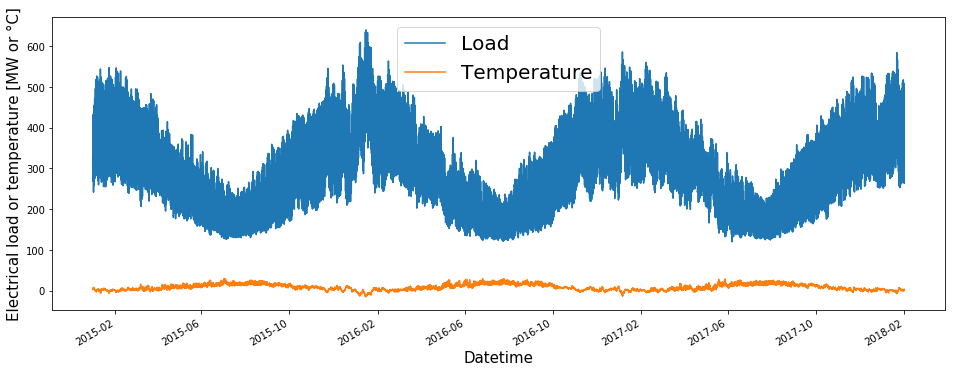

In [352]:
df.plot(figsize=(16,6))
plt.xlabel('Datetime', fontsize=15)
plt.ylabel('Electrical load or temperature [MW or °C]', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


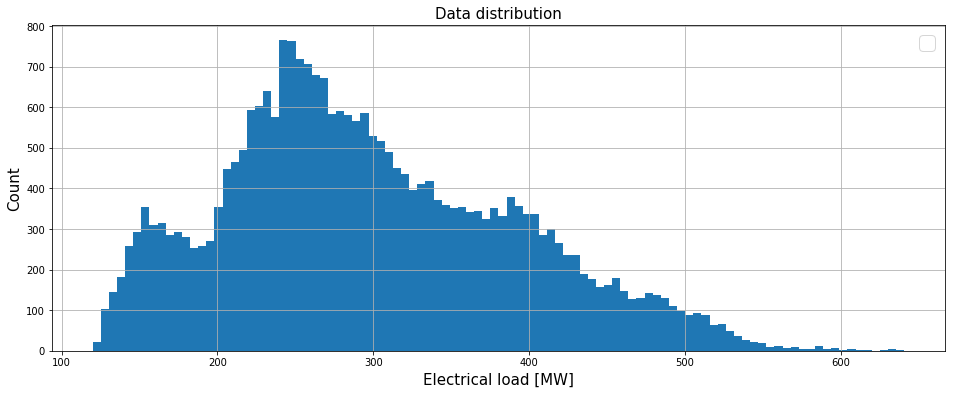

In [353]:
df['Load'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Electrical load [MW]', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


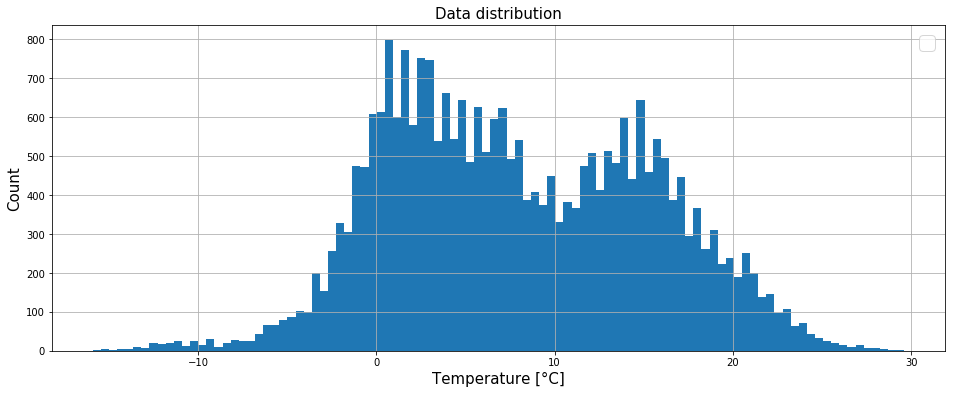

In [354]:
df['Temperature'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

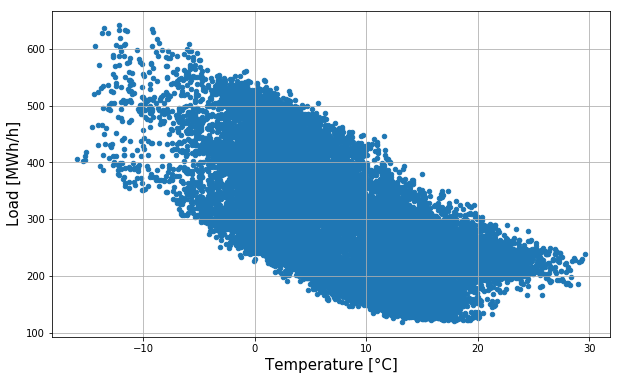

In [355]:
df.plot.scatter('Temperature', 'Load', figsize=(10,6))
plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Load [MWh/h]', fontsize=15)
plt.grid()

Text(0,0.5,'Electrical load [MWh/h]')

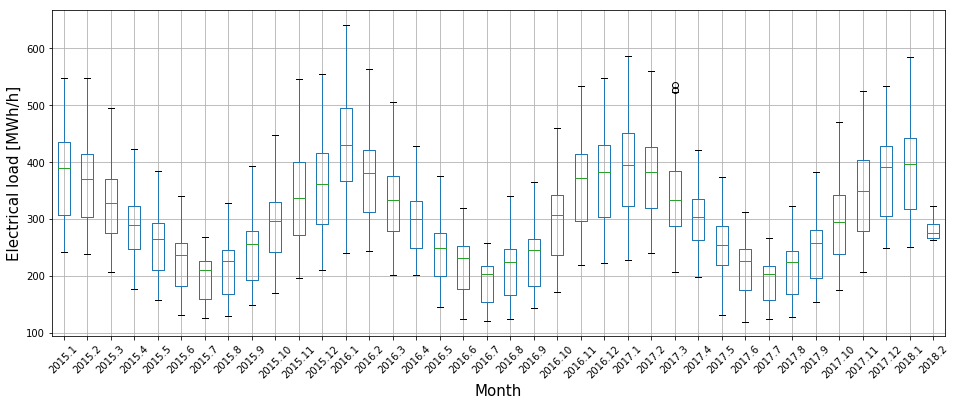

In [356]:
groups = df['Load'].groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(g[1].values, columns=[str(g[1].index.year[0])+'.'+str(g[1].index.month[0])]) for g in groups], axis=1)
months.boxplot(figsize=(16,6), rot=45)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Electrical load [MWh/h]', fontsize=15)

Text(0,0.5,'Temperature [°C]')

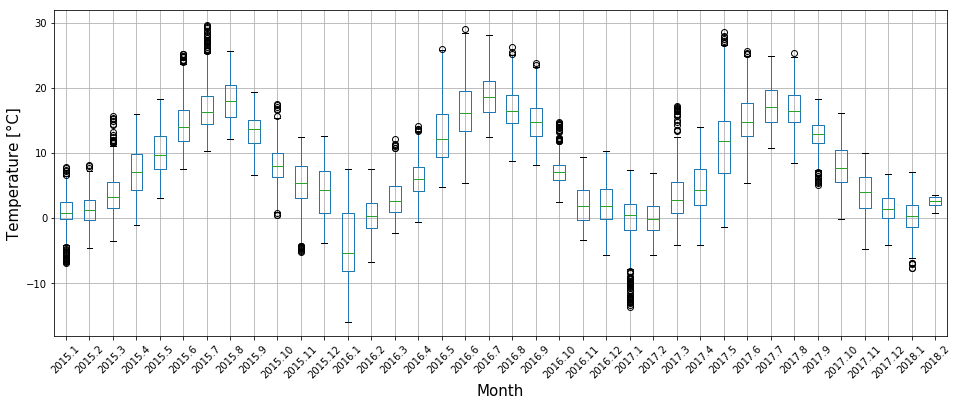

In [362]:
groups = df['Temperature'].groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(g[1].values, columns=[str(g[1].index.year[0])+'.'+str(g[1].index.month[0])]) for g in groups], axis=1)
months.boxplot(figsize=(16,6), rot=45)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Temperature [°C]', fontsize=15)

Text(0,0.5,'Electrical load [MWh/h]')

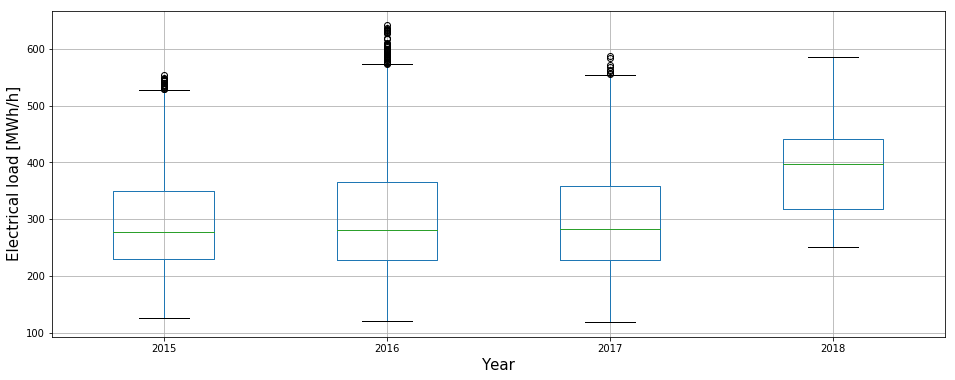

In [357]:
groups = df['Load'].groupby(pd.Grouper(freq='Y'))
years = pd.concat([pd.DataFrame(g[1].values, columns=[g[1].index.year[0]]) for g in groups], axis=1)
years.boxplot(figsize=(16,6))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Electrical load [MWh/h]', fontsize=15)

Text(0,0.5,'Temperature ["C]')

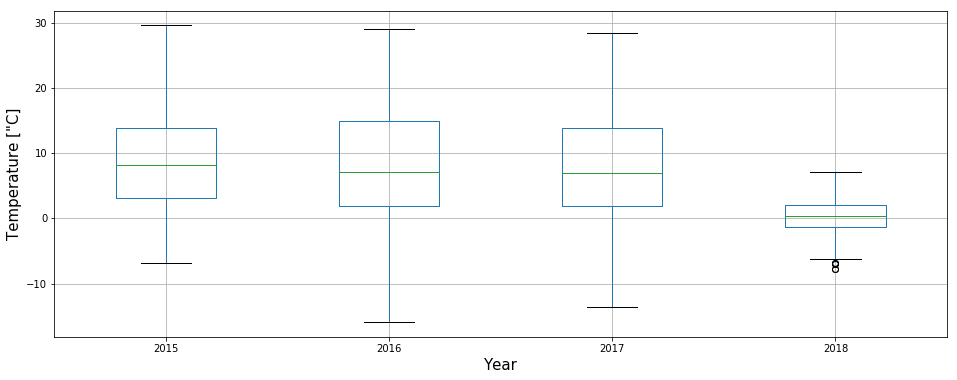

In [363]:
groups = df['Temperature'].groupby(pd.Grouper(freq='Y'))
years = pd.concat([pd.DataFrame(g[1].values, columns=[g[1].index.year[0]]) for g in groups], axis=1)
years.boxplot(figsize=(16,6))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Temperature ["C]', fontsize=15)

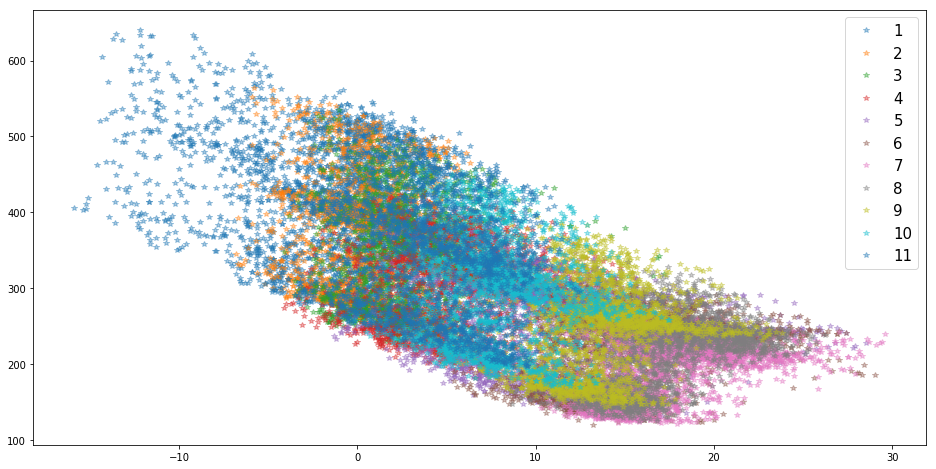

In [364]:
nrows=4; ncols=3;
fig = plt.figure(figsize=(16,8))
for i in range(1,12):
    plt.plot(df['Temperature'][df.index.month == i], df['Load'][df.index.month == i], '*', alpha=0.4, label=str(i))
plt.legend(fontsize=15)

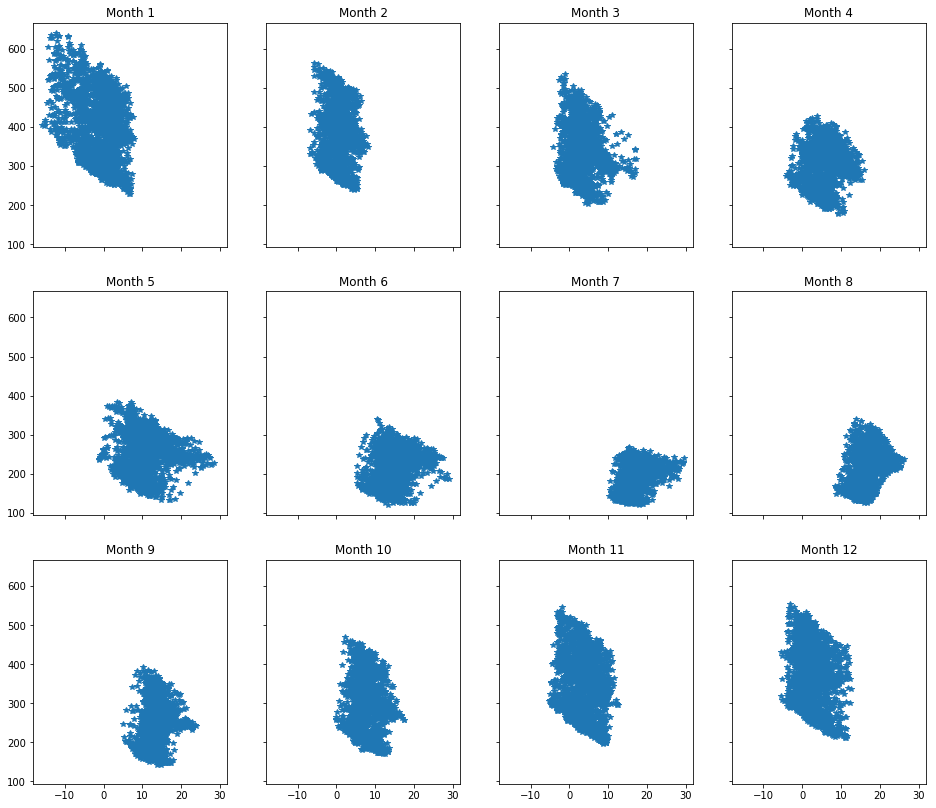

In [366]:
nrows=3; ncols=4; i=1;
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', sharey='all', figsize=(16,14))
for irow in range(nrows):
    for icol in range(ncols):
        axes[irow, icol].plot(df['Temperature'][df.index.month == i], df['Load'][df.index.month == i], '*')
        axes[irow, icol].set_title('Month '+str(i))
        i = i+1

## Scale distributions

In [367]:
mu_load = df['Load'].mean()
sigma_load = df['Load'].std()
y_data = (df['Load'].values-mu_load)/sigma_load

In [368]:
mu_temp = df['Temperature'].mean()
sigma_temp = df['Temperature'].std()
x_data = (df['Temperature'].values-mu_temp)/sigma_temp
x_data = x_data.reshape(-1,1)

## Create supervised problem

In [369]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in test set: {0}.'.format(len(X_test)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in test data: {}".format(X_test.shape))
print("Shape of output in test data: {}".format(y_test.shape))

Data points in train set: 20274.
Data points in test set: 6759.
Shape of features in training data: (20274, 1)
Shape of output in training data: (20274,)
Shape of features in test data: (6759, 1)
Shape of output in test data: (6759,)


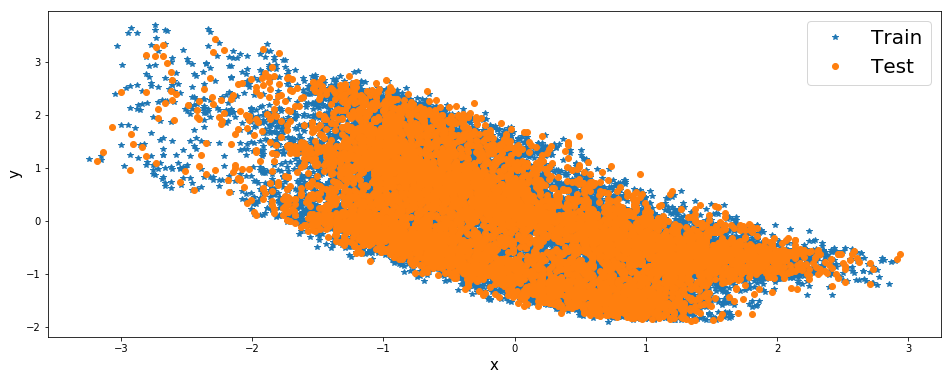

In [453]:
plt.figure(figsize=(16,6))
plt.plot(X_train, y_train, '*', label='Train')
plt.plot(X_test, y_test, 'o', label='Test')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Mixture density network

### Build network

In [486]:
def build_mdn(X):
    h = Dense(units=10, activation='relu', kernel_initializer='lecun_normal')(X)
    h = Dense(units=10, activation='relu', kernel_initializer='lecun_normal')(h)
    h = Dense(units=10, activation='relu', kernel_initializer='lecun_normal')(h)
    
    weights = Dense(units=K, activation='linear')(h)
    mus = Dense(units=K, activation='linear')(h)
    sigmas = Dense(units=K, activation=tf.exp)(h) # Could be softplus
    
    return weights, mus, sigmas

In [487]:
X_ph = tf.placeholder(tf.float32, [None, 1])
y_ph = tf.placeholder(tf.float32, [None])

In [488]:
weights, mus, sigmas = build_mdn(X_ph)

cat = Categorical(logits=weights)
components = []
components.extend([Normal(loc=mu, scale=sigma) for mu, sigma 
                   in zip(tf.unstack(tf.transpose(mus)),tf.unstack(tf.transpose(sigmas)))])
y = ed.models.Mixture(cat=cat, components=components)

inference = ed.MAP(data={y: y_ph})

### Optimizer

In [489]:
lr_ph = tf.placeholder(tf.float32, shape=[], name='lr')
optim = 'Adam'
if optim == 'Adam':
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_ph,
                                       beta1=0.9,
                                       beta2=0.999,
                                       epsilon=1e-08)
elif optim == 'RMSprop':
    optimizer = tf.train.RMSPropOptimizer(learning_rate=lr_ph,
                                          decay=0.9,
                                          epsilon=1e-10)
elif optim == 'Adagrad': 
    optimizer = tf.train.AdagradOptimizer(learning_rate=lr_ph,
                                          initial_accumulator_value=0.1,
                                          use_locking=False)
    
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

In [493]:
sess = ed.get_session()
tf.set_random_seed(1337)
tf.global_variables_initializer().run()

### Predict before training

In [490]:
n_pred = 2000
X_pred = np.reshape(np.linspace(1.25*X_train.min(), 1.25*X_train.max(), n_pred), (n_pred, 1))

In [494]:
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})

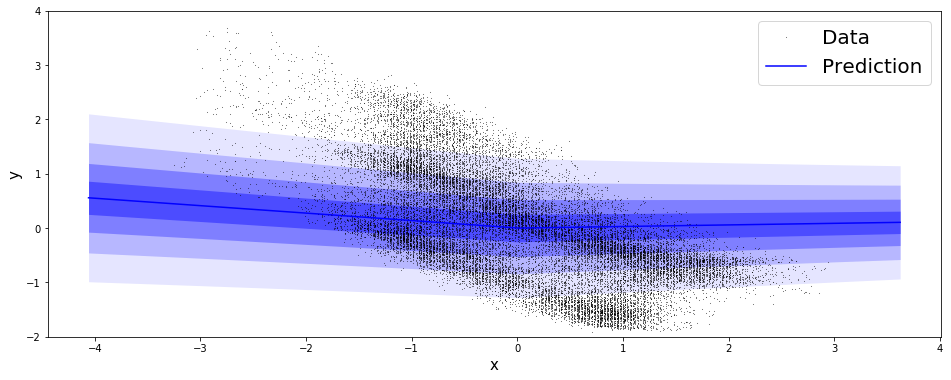

In [495]:
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-20, 20, 1000)
quantiles = np.arange(0.1,1,0.1)
mixture = Mixture(y, quantiles, pred_weights, pred_mus, pred_sigmas)
plot_uncertainty(mixture, X_pred)

### Inference

In [496]:
mse_mdn = np.array([]).reshape(0,3)
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [497]:
lrs = [1e-3]
for lr in lrs: 
    n_epoch_add = 100
    train_loss = np.concatenate((train_loss,np.zeros(n_epoch_add)))
    test_loss = np.concatenate((test_loss,np.zeros(n_epoch_add)))
    inference.n_print = 10
    inference.progbar.target = n_epoch+n_epoch_add
    for i in range(n_epoch,n_epoch+n_epoch_add):
        X_batches = np.array_split(X_train, batch_size, axis=0)
        y_batches = np.array_split(y_train, batch_size, axis=0)
        
        for X_batch, y_batch in zip(X_batches,y_batches):
            info_dict = inference.update(feed_dict={X_ph: X_batch, y_ph: y_batch, lr_ph: lr})
        
        info_dict['t'] = i+1
        train_loss[i] = info_dict['loss']
        test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: X_test, y_ph: y_test})
        inference.print_progress(info_dict)

    n_epoch = n_epoch+n_epoch_add

100/100 [100%] ██████████████████████████████ Elapsed: 68s | Loss: 317.836


### Plot diagnostics

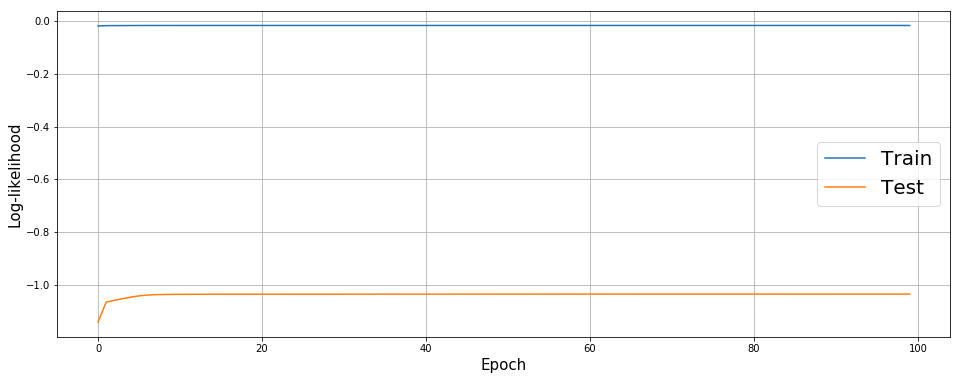

In [498]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [499]:
train_weights, train_mus, train_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_train})
test_weights, test_mus, test_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_test})
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})

### Plot predictions

In [500]:
class Mixture():
    
    def __init__(self, y, quantiles, pred_weights, pred_mus, pred_sigmas):
        # If x does not have high enough resolution. then this will not work. So make a check that enough points capture the pdf
        self.y = y
        self.quantiles = quantiles
        self.pred_weights = pred_weights
        self.pred_mus = pred_mus
        self.pred_sigmas = pred_sigmas
        
        self.mean()
        self.pdf()
        self.cdf()
        self.quantile()
    
    def mean(self):
        
        mean = self.pred_weights*self.pred_mus
        self.mean_mix = np.sum(mean, axis=1)
        
    def pdf(self):

        pdf = np.empty([len(self.y), self.pred_weights.shape[0], self.pred_weights.shape[1]])
        for i in range(self.pred_weights.shape[0]):
            for j in range(self.pred_weights.shape[1]):
                pdf[:,i,j] = self.pred_weights[i,j] * stats.norm.pdf(self.y, self.pred_mus[i,j], self.pred_sigmas[i,j])
        self.pdf_mix = np.sum(pdf, axis=2)
    
    def cdf(self):

        cdf = np.empty([len(self.y), self.pred_weights.shape[0], self.pred_weights.shape[1]])
        for i in range(self.pred_weights.shape[0]):
            for j in range(self.pred_weights.shape[1]):
                cdf[:,i,j] = self.pred_weights[i,j] * stats.norm.cdf(self.y, self.pred_mus[i,j], self.pred_sigmas[i,j])
        self.cdf_mix = np.sum(cdf, axis=2)
    
    def quantile(self):
        
        self.quantiles_mix = np.empty([self.pred_weights.shape[0], len(self.quantiles)])            
        for i in range(self.pred_weights.shape[0]):
            for k, q in enumerate(self.quantiles):
                
                f = interp1d(self.y, self.cdf_mix[:,i], kind='linear')
                self.quantiles_mix[i,k] = optimize.brentq(lambda y: f(y)-q, self.y[0], self.y[-1])


#### Plot uncertainty

In [501]:
def plot_uncertainty(mixture, X_pred):
    n_quantiles = len(mixture.quantiles)
    alpha = np.linspace(0.1,0.4,int(n_quantiles/2))
    fig, ax = plt.subplots(figsize=(16,6))
    plt.plot(x_data, y_data, '*k', alpha=0.5, markersize=0.3, label='Data')
    for i in range(int(n_quantiles/2)):
        ax.fill_between(X_pred[:,0], mixture.quantiles_mix[:,i], mixture.quantiles_mix[:,-(1+i)], color='b', linewidth=0.0, alpha=alpha[i])

    ax.plot(X_pred, mixture.mean_mix, 'b', label='Prediction')
    plt.ylim([-2, 4])
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.legend(fontsize=20)

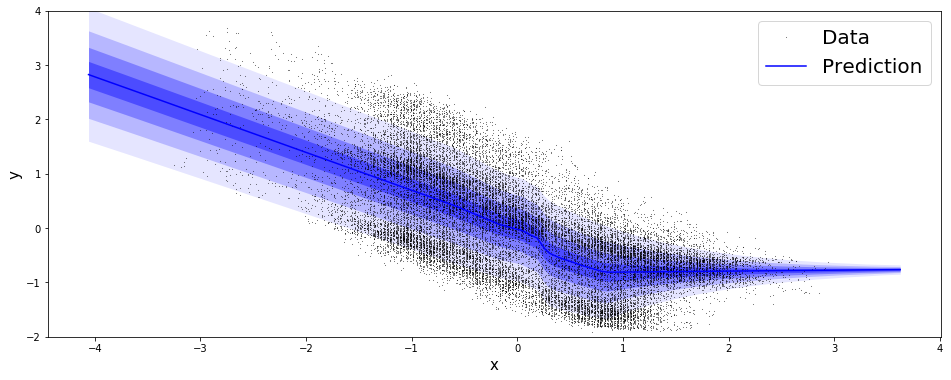

In [502]:
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-20, 20, 1000)
quantiles = np.arange(0.1,1,0.1)
mixture = Mixture(y, quantiles, pred_weights, pred_mus, pred_sigmas)
plot_uncertainty(mixture, X_pred)

#### Plot data generation

In [503]:
def sample_from_mixture(x, pred_weights, pred_mus, pred_sigmas, amount):

    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, mus, sigmas) in enumerate(zip(pred_weights, pred_mus, pred_sigmas)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(mus[index], sigmas[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
        
    return samples

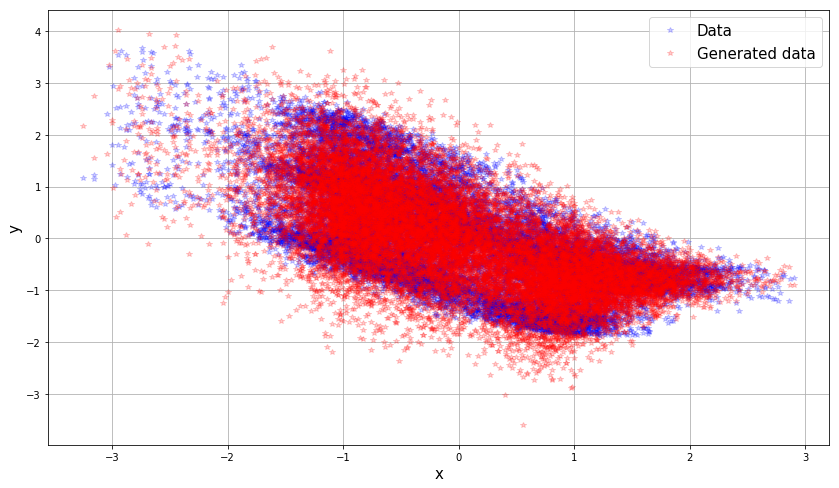

In [504]:
samples = sample_from_mixture(X_train, train_weights, train_mus, train_sigmas, amount=len(X_train))
plt.figure(figsize=(14,8))
plt.plot(X_train, y_train, 'b*', alpha=0.2, label='Data')
plt.plot(samples[:,0], samples[:,1], 'r*', alpha=0.2, label='Generated data')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=15)
plt.grid()